**AVISO: Este módulo deve utilizar o kernel do LeituraFicheiros_PBD-grupo12.ipynb**

# Gráficos

Esta é uma fase em que fazemos a análise descritiva para iniciarmos a fase do modelo.

Esta fase está dividida em duas partes, sendo uma delas destinada à análise descritiva do parquet **jogos** (com train.csv e test.csv juntos) e a outra destinada à análise depois do feature engineering, do parquet **Games**.

## Funções a utilizar

As funções que se seguem servem para desenhar os gráficos neste segmento.

In [51]:
def plotHistogram(df, xcol, huecol=None):
    sns.histplot(data=df, x=xcol, hue=huecol, multiple="stack")

In [52]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)

In [53]:
def plot(df, xcol, ycol):
    sns.lineplot(data=df, x=xcol, y=ycol)

In [54]:
def plotBar(df, xcol, ycol, huecol=None):
    sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)
    plt.xticks(rotation=90)
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)

In [55]:
def plotScatter(df, xcol, ycol, size=10, huecol=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=df, x=xcol, y=ycol, s=size, ax=ax, hue=huecol)

In [56]:
def plotScatterMatrix(df, huecol=None):
    sns.pairplot(data=df, hue=huecol)

In [57]:
def plotCorrelationMatrix_1(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [58]:
def plotCorrelationMatrix_2(df):
    # compute a correlation matrix and convert to long-form
    corr_mat = df.corr().stack().reset_index(name="correlation")
    # draw each cell as a scatter point with varying size and color
    g = sns.relplot(
        data=corr_mat,
        x="level_0", y="level_1", hue="correlation", size="correlation",
        palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
        height=10, sizes=(50, 250), size_norm=(-.2, .8),
    )

    # tweak the figure to finalize
    g.set(xlabel="", ylabel="", aspect="equal")
    g.despine(left=True, bottom=True)
    g.ax.margins(.02)
    for label in g.ax.get_xticklabels():
        label.set_rotation(90)
    for artist in g.legend.legendHandles:
        artist.set_edgecolor(".7")

In [59]:
def plotPie(df, labels, huecol=None):
    plt.pie(df, labels, huecol)

## Graficos sobre a base de dados jogos original

Iremos retirar uma amostra da base de dados original (**jogos**), mas somente para desenhar alguns gráficos que têm uma grande exigência computacional. Sendo assim, será dito quando for utilizada a amostra.

In [60]:
# reduzir o tamanho da base de dados para a visualização dos dados que temos após o feature engineering
seed = 5
with_replacement = False
fraction = 0.05          # reduce to 5%
small_jogos1 = jogos.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)
small_jogos1.count()

1313892

### Nulos

Ver a quantidade de nulls através de um gráfico de barras. O eixo do y representa a quantidade de nulos.

In [61]:
nulos = []
for i in jogos.columns:
    nulos_texto = jogos.select(F.count(F.when(jogos[i].isNull(), True))).collect()[0][0]
    nulos.append([i, nulos_texto])

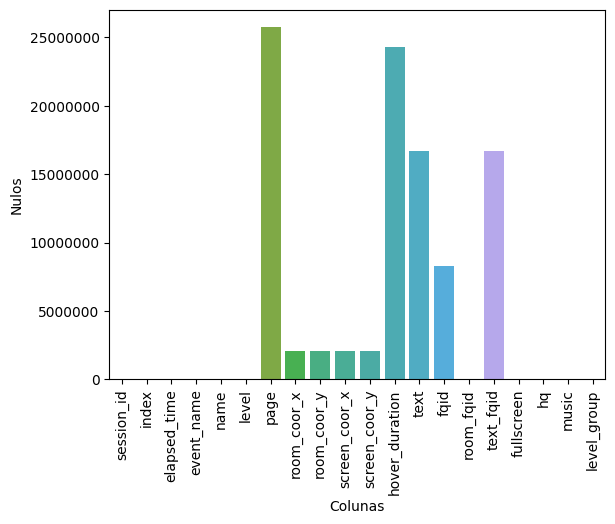

In [62]:
# Definindo o schema do dataframe
schema = StructType([
    StructField("Colunas", StringType(), True),
    StructField("Nulos", IntegerType(), True)
])

# Criando o dataframe
df_plot = spark.createDataFrame(nulos, schema).toPandas()

plotBar(df_plot, "Colunas", "Nulos", huecol=None)

É possivel visualizar que as colunas **page** e **hover_duration** são as colunas com mais valores omissos.

### Correlation matrix

Fazer uma matriz de correlação de forma a observar a relação entre as variáveis numéricas presentes no DataSet de **jogos**.

In [63]:
cols_to_forget = ["page", "hover_duration", "text", "text_fqid"]
jogos1 = jogos.drop(*cols_to_forget)

Foram retiradas as colunas com muitos valores omissos, como observado na primeira fase e no gráfico de barras anterior.

In [64]:
numeric_cols = ["session_id", "index","elapsed_time","level","room_coor_x","room_coor_y","screen_coor_x","screen_coor_y","fullscreen","hq","music"]

# The columns to compute correlations
cols_corr = numeric_cols

# DataSet sem nulos (Aqui preferimos usar o DataSet completo para obter uma maior veracidade das correlações)
jogosNoNull = jogos1.na.drop()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(jogosNoNull).select(vector_col)

# get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

23/04/09 01:16:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/09 01:16:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [65]:
del jogosNoNull

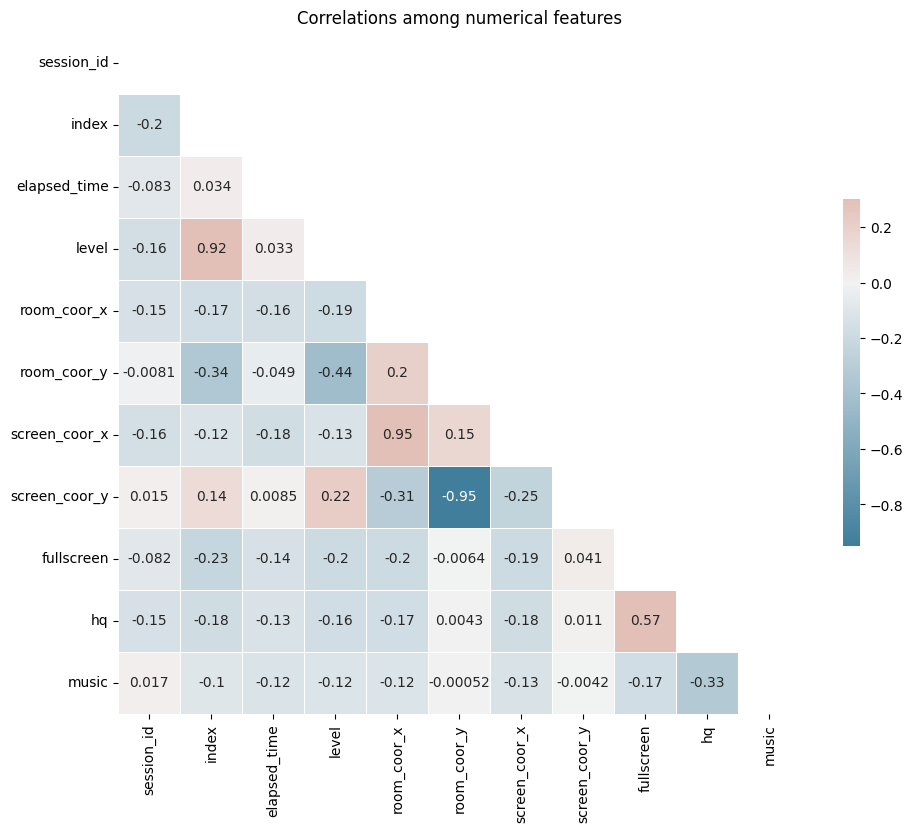

In [66]:
df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix_1(df_plot, annot=True)
plt.title('Correlations among numerical features')
plt.show()

Verificamos que a maioria das variáveis não se correlacionam, tendo valores de correlação negativos ou nulos. Alguns casos fogem à regra e apresentam correlação muito elevada

### Coordenadas de click

Iremos ver a dispersão de pontos das coordenadas de cliques, tanto para do ecrã, quanto para da sala. 

**Nota:** Para estes dois gráficos foi utilizado a amostra mais reduzida porque existem pontos muito semelhantes onde as pessoas clicam, assim para não exigir demasiado da máquina mas termos uma ideia da dispersão.

#### Clickes aleatórios

Em baixo podemos visualizar uma amostra dos cliques no ecrã no jogador e, fazendo uma análise, não é posivel encontrar um padrão, apenas podemos concluir que existe uma concentração destes

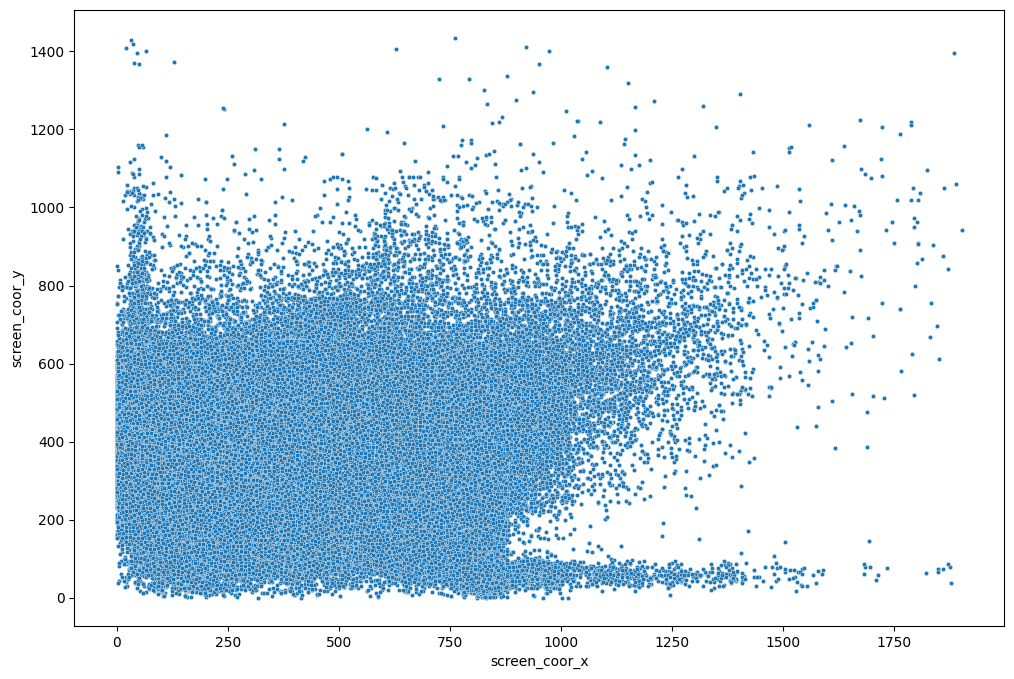

In [67]:
df_plot = (small_jogos1
          .select("screen_coor_x", "screen_coor_y")
          .toPandas())

plotScatter(df_plot, "screen_coor_x", "screen_coor_y", huecol=None)

A mesma conclusão se pode retirar sobre os cliques das salas dos jogos, mas é possivel visualizar uma coisa interessante, isto é, no canto inferior direito não existe nenhum clique

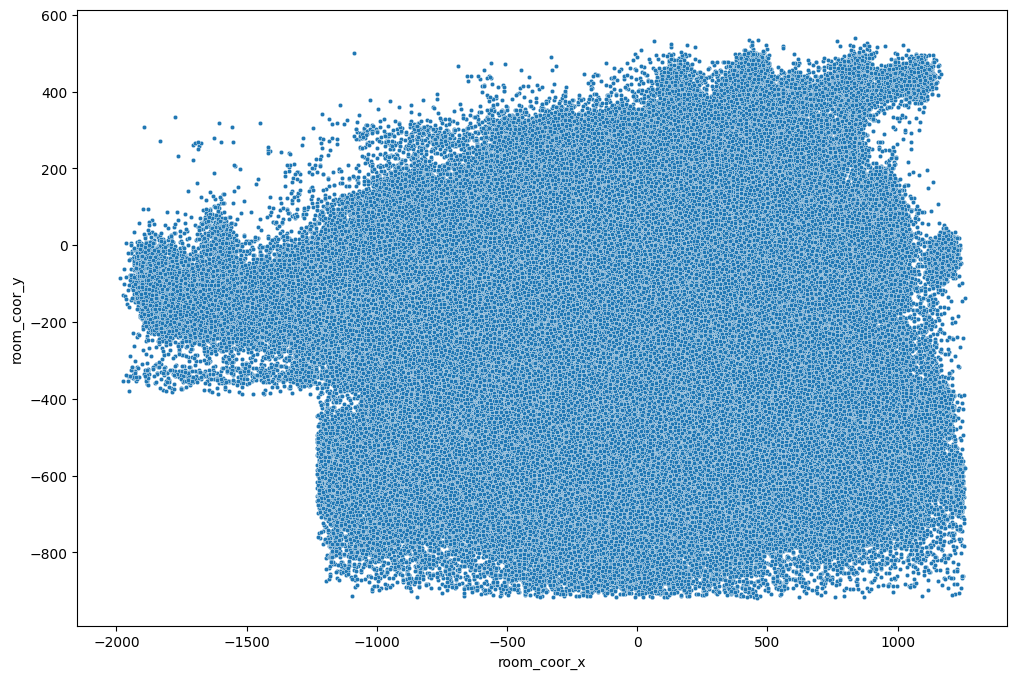

In [68]:
df_plot = (small_jogos1
          .select("room_coor_x", "room_coor_y")
          .toPandas())
plotScatter(df_plot, "room_coor_x", "room_coor_y", huecol=None)

Mas o que acontece se relacionar-mos estes clickes com as salas e com o tipo de evento ?

#### Clickes filtrados e escolhidos

In [69]:
jogos.select("event_name").distinct().show()

+------------------+
|        event_name|
+------------------+
|    navigate_click|
|      object_click|
|    notebook_click|
| observation_click|
|    cutscene_click|
|        checkpoint|
|notification_click|
|      person_click|
|         map_hover|
|         map_click|
|      object_hover|
+------------------+



Em baixo, podemos visualizar a concentração dos cliques nas pessoas. A concentração dos pontos à esquerda corresponde ao avô e a concentração de pontos corresponde ao animal

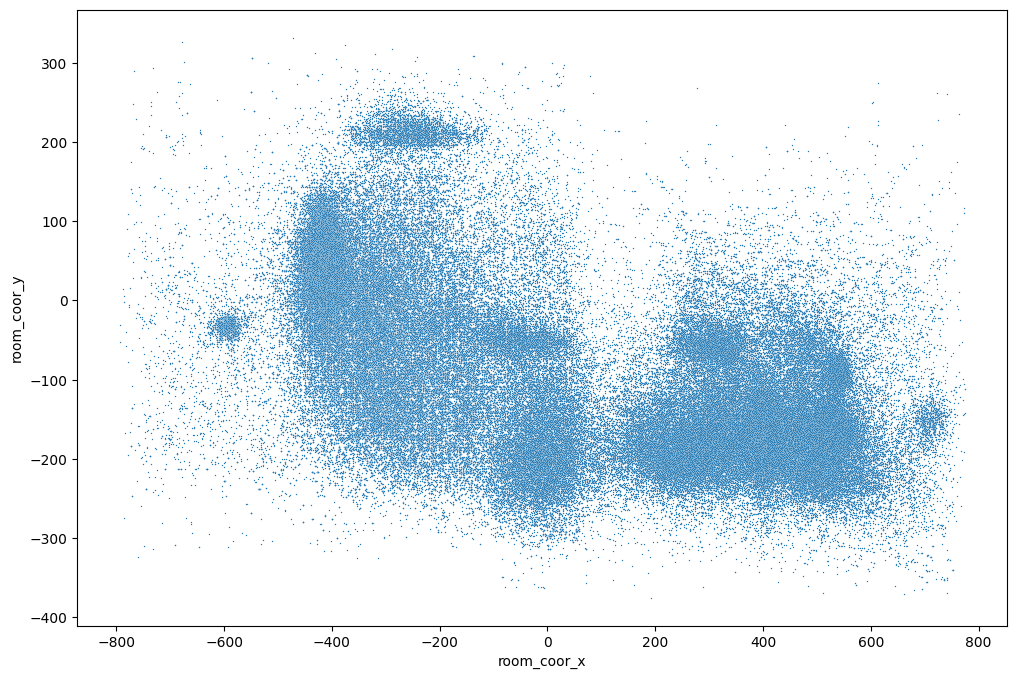

In [70]:
df_plot = (jogos
          .filter((F.col("event_name")=="person_click") & (F.col("room_fqid")=="tunic.historicalsociety.closet"))
          .select("room_coor_x", "room_coor_y")
          .toPandas())
#room1
plotScatter(df_plot, "room_coor_x", "room_coor_y", 1,huecol=None)

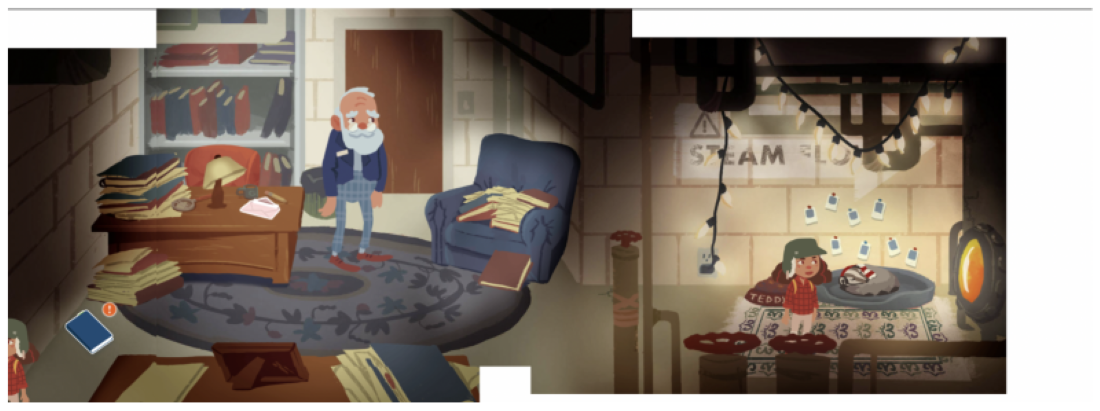

- - -

Neste segundo exemplo, podemos visualizar as coordenadas dos pontos de um dos quartos do jogo e, analisando com atenção, é possivel verificar que existe uma correspondência.

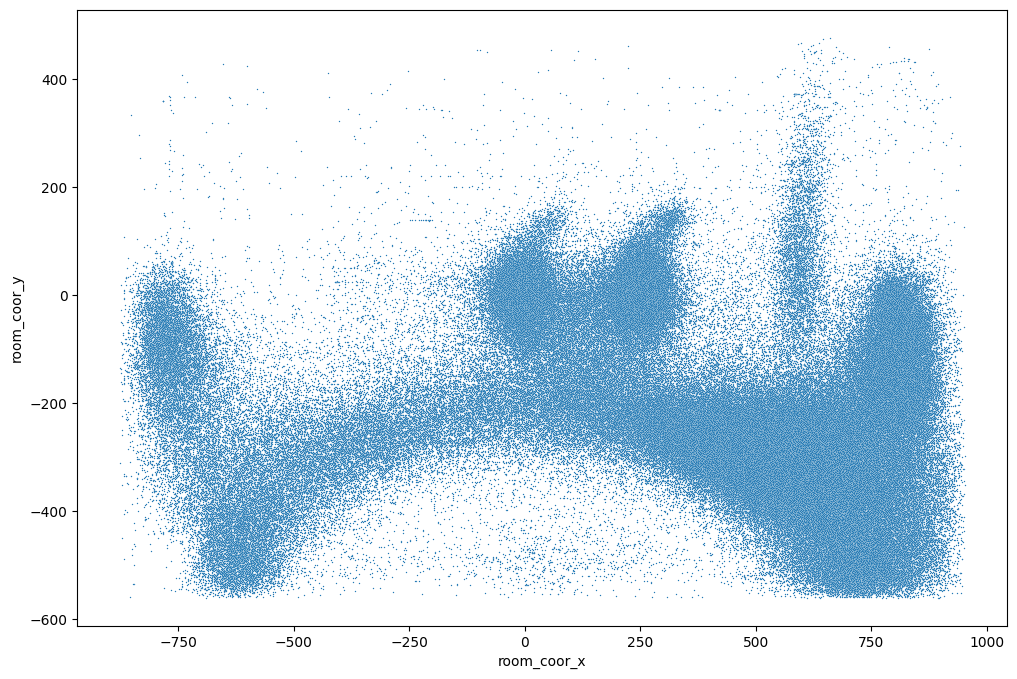

In [71]:
df_plot = (jogos
          .filter((F.col("event_name")=="navigate_click") & (F.col("room_fqid")=="tunic.capitol_0.hall"))
          .select("room_coor_x", "room_coor_y")
          .toPandas())
# room7
plotScatter(df_plot, "room_coor_x", "room_coor_y", 1,huecol=None)

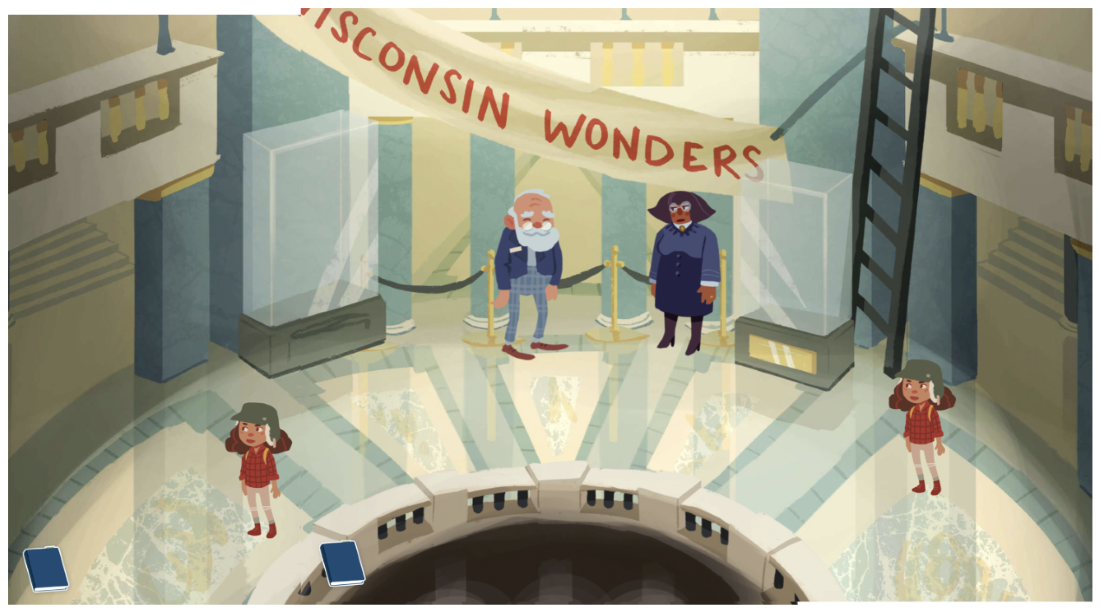

- - -

Neste exemplo, podemos visualizar a concentração dos pontos correspondentes às interações com as pessoas. Se analisarmos corretamente, é possivel verificar que existe duas concentrações de pontos (há pessoas à esquerda e á direita da árvore) com uma partem "vazia" no meio (correspondente à árvore)

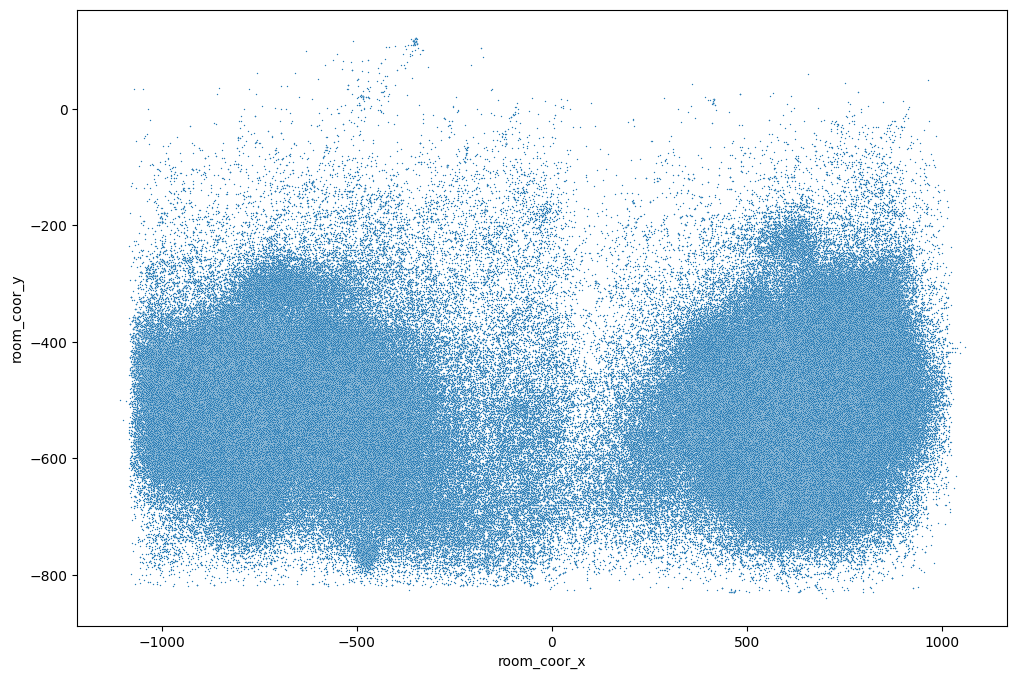

In [72]:
df_plot = (jogos
          .filter((F.col("event_name")=="person_click") & (F.col("room_fqid")=="tunic.wildlife.center"))
          .select("room_coor_x", "room_coor_y")
          .toPandas())
# room16
plotScatter(df_plot, "room_coor_x", "room_coor_y", 1,huecol=None)

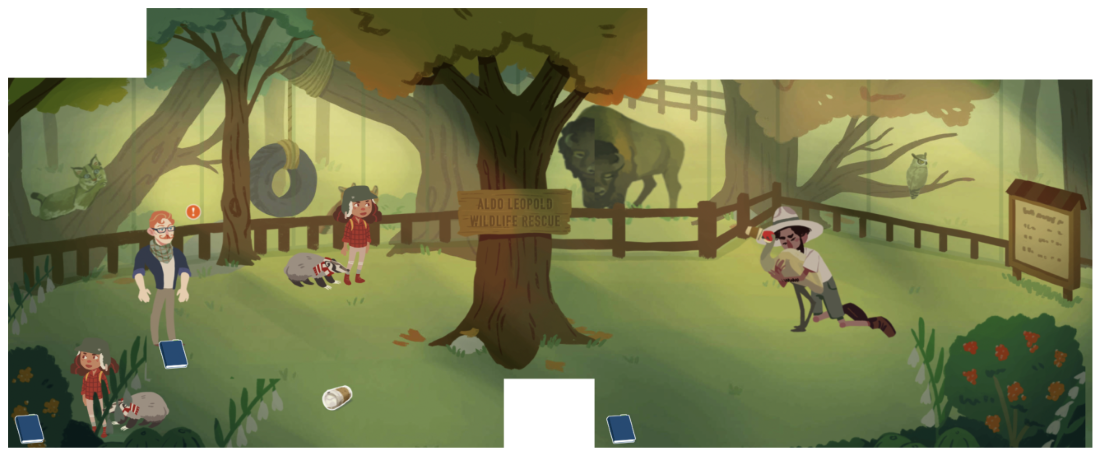

- - -

Aqui está mais outro exemplo de como os pontos, correspondentes aos clickes de navegação, formam a sala.

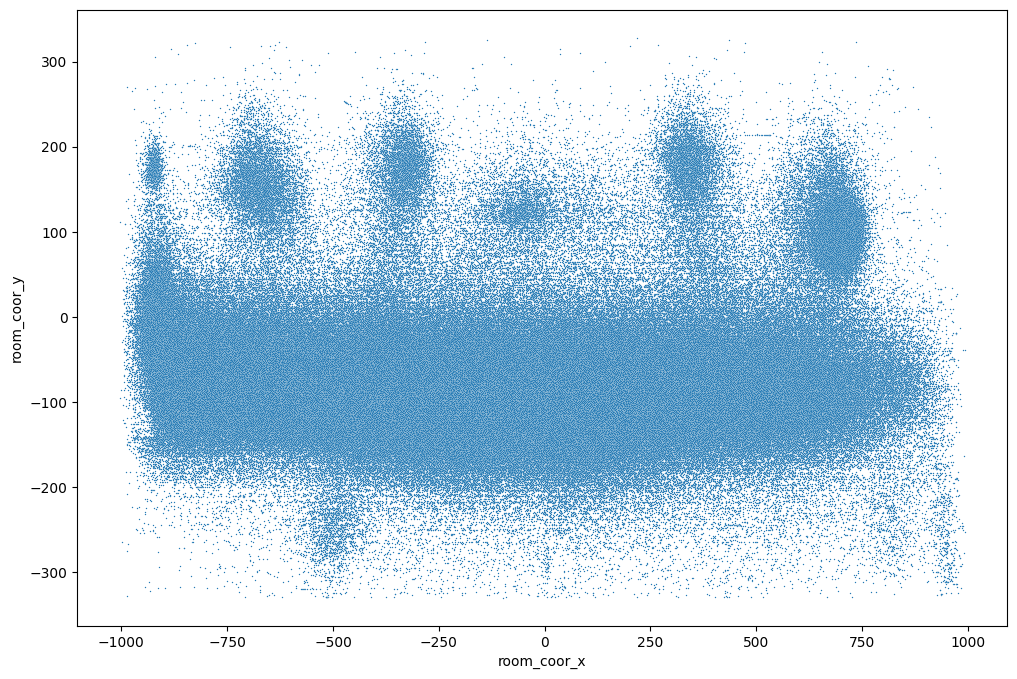

In [73]:
df_plot = (jogos
          .filter((F.col("event_name")=="navigate_click") & (F.col("room_fqid")=="tunic.kohlcenter.halloffame"))
          .select("room_coor_x", "room_coor_y")
          .toPandas())
#room5
plotScatter(df_plot, "room_coor_x", "room_coor_y", 1,huecol=None)

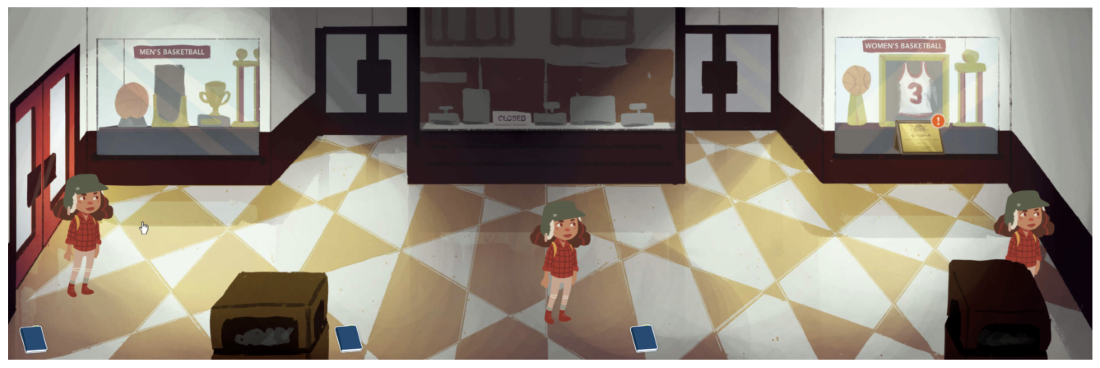

### Interações por nivel

Um gráfico que indica quantas linhas da base de dados existem por nível (número de linhas). Assim, conseguimos ver os níveis mais longos e em que as pessoas costumam ter mais interações com a tela.

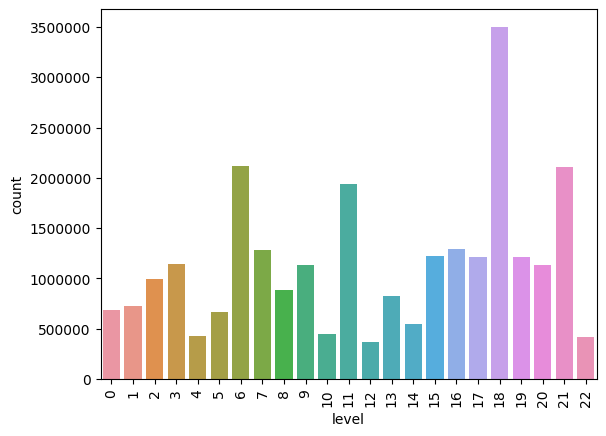

In [74]:
df_plot = (jogos
            .groupBy("level")
            .count()
            .toPandas())
plotBar(df_plot, "level", "count", huecol=None)

Agora queremos ver essa distribuição, mas por grupos de níveis num gráfico circular.

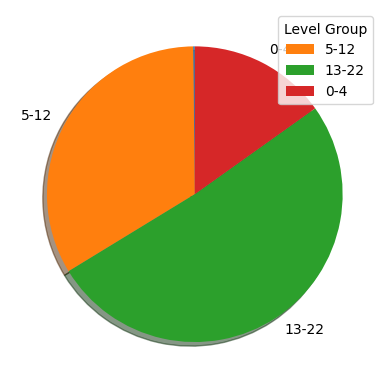

In [75]:
df_plot = (jogos
           .groupBy("level_group")
           .count()
           .toPandas())
plt.pie(df_plot["count"], labels = df_plot["level_group"], startangle=90, shadow=True)
plt.legend(title = "Level Group")
plt.show()

### Diferença dos tipos de eventos

Neste gráfico seguinte iremos ver a frequência em que os diferentes tipos de eventos aparecem na base de dados.

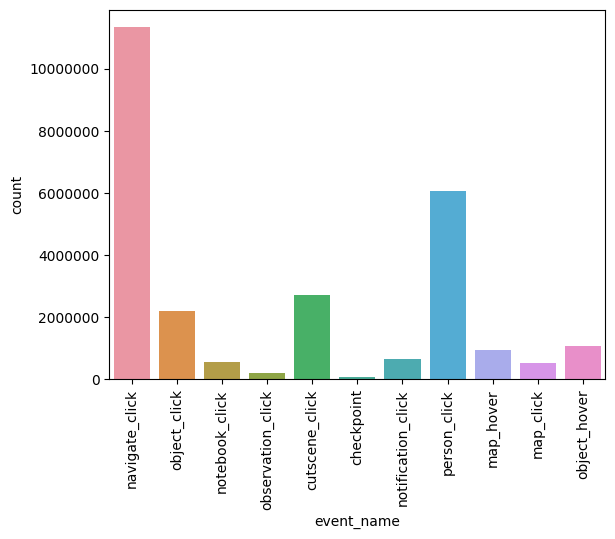

In [76]:
df_plot = (jogos.select("event_name")
           .groupBy("event_name")
           .count()
           .toPandas())

plotBar(df_plot, "event_name", "count", huecol=None)

### Diferença dos names

Veremos agora a variável `name` e a frequência de cada acontecimento desta variável, num gráfico de barras.

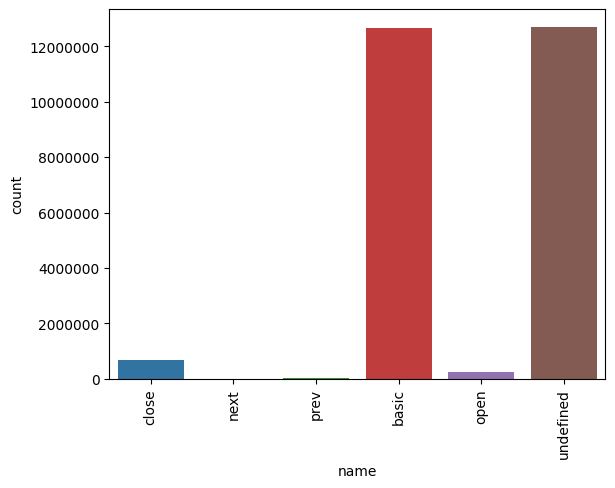

In [77]:
df_plot = (jogos.select("name")
           .groupBy("name")
           .count()
           .toPandas())

plotBar(df_plot, "name", "count", huecol=None)

Vemos uma dispersão muito grande de uns acontecimentos para outros e uma grande taxa de indefinidos. Assim, decidimos retirar esta coluna na fase de feature engineering.

### Colunas com valores binários

Iremos analisar as variáveis `fullscreen`,`hq` e `music` que adquirem um valor de "Sim" ou "Não". Veremos a proporção de como aparecem, desenhando gráficos circulares.

#### Fullscreen

In [78]:
jogos1 = jogos.select("fullscreen")
jogos1 = jogos1.dropna()
df_plot = (jogos1.select("fullscreen")
           .groupBy("fullscreen")
           .count()
           .toPandas())

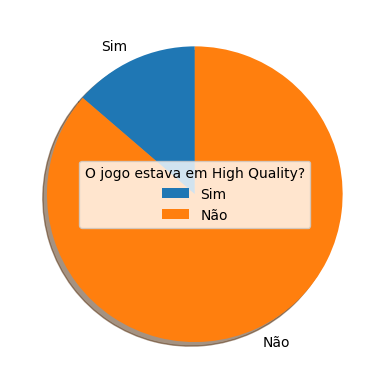

In [79]:
df_plot['fullscreen'] = df_plot['fullscreen'].replace({1.0: 'Sim', 0.0:"Não"})
plt.pie(df_plot["count"], labels = df_plot["fullscreen"], startangle=90, shadow=True)
plt.legend(title = "O jogo estava em High Quality?")
plt.show()

A grande generalidade das pessoas joga o jogo sem a funcionalidade de `fullscreen` ativa.

#### High Quality

In [80]:
jogos1 = jogos.select("hq")
jogos1 = jogos1.dropna()
df_plot = (jogos1.select("hq")
           .groupBy("hq")
           .count()
           .toPandas())

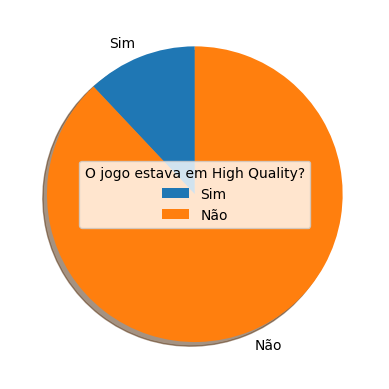

In [81]:
df_plot['hq'] = df_plot['hq'].replace({1.0: 'Sim', 0.0:"Não"})
plt.pie(df_plot["count"], labels = df_plot["hq"], startangle=90, shadow=True)
plt.legend(title = "O jogo estava em High Quality?")
plt.show()

Relativamente à qualidade dos gráficos, vemos que a proporção é mais ou menos semelhante à de pessoas que jogam o jogo com tela cheia.

#### Music

In [82]:
jogos1 = jogos.select("music")
jogos1 = jogos1.dropna()
df_plot = (jogos1.select("music")
           .groupBy("music")
           .count()
           .toPandas())

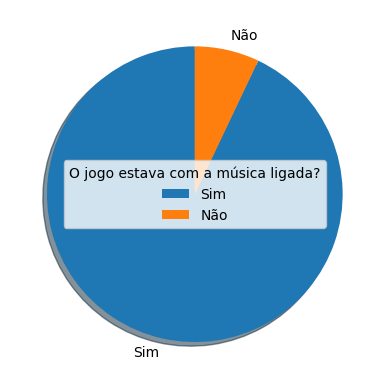

In [83]:
df_plot['music'] = df_plot['music'].replace({1.0: 'Sim', 0.0:"Não"})
plt.pie(df_plot["count"], labels = df_plot["music"], startangle=90, shadow=True)
plt.legend(title = "O jogo estava com a música ligada?")
plt.show()

Diferente dos outros, uma esmagadora maioria das pessoas tem a música ligada ao jogar o jogo. O que nos leva para uma conclusão geral acerca disto.

Tal como vimos no primeiro ficheiro e na imagem abaixo, a predefinição do jogo ao entrarmos é de ter a música ativada e as opções de tela cheia e maior qualidade desativadas. O que nos leva a crer que as pessoas não se importam muito com as configurações ao iniciarem a história. 

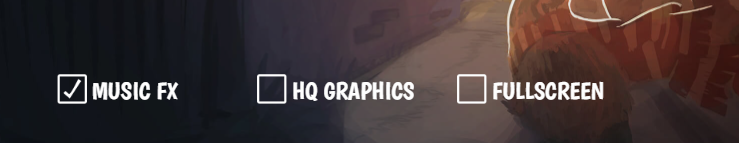

### Elapsed Time

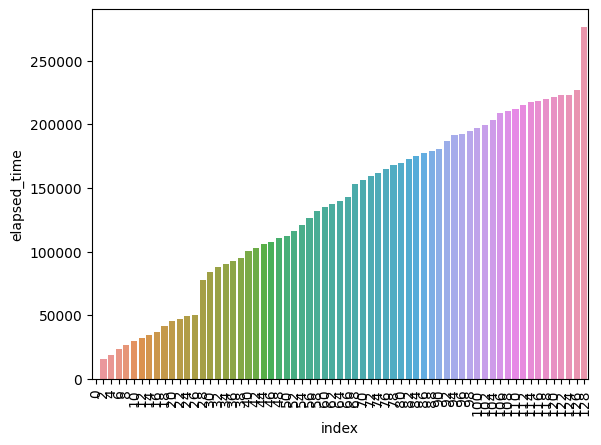

In [84]:
df_plot = (jogos.filter((F.col("session_id")==20110310350354548) & (F.col("level_group")=="0-4") & (F.col("index")%2 ==0))
           .select("index", "elapsed_time")
           .sort(F.asc("index"))
           .toPandas())
plotBar(df_plot, "index", "elapsed_time")

O gráfico acima comprova que a coluna **elapsed time** vai contando o tempo total de jogo de cada sessão (começa em 0 e acaba com um valor alto). No eixo do x está a variável **index** que é o respetivo número de cada click de cada sessão.

#### Comparação entre a sessão mais longa e a mais curta

Neste passo, iremos comparar o **elapsed_time** com o **index**, da sessão mais curta e mais longa, respetivamente, com o objetivo de visualizar se existe alguma coisa de interessante.

##### Mais curta

In [85]:
jogos.select("*").groupBy("session_id").agg(F.max(F.col("elapsed_time"))).sort(F.col("max(elapsed_time)").asc()).show(2)

+-----------------+-----------------+
|       session_id|max(elapsed_time)|
+-----------------+-----------------+
|21020618143279870|              999|
|22040212485055840|           455571|
+-----------------+-----------------+
only showing top 2 rows



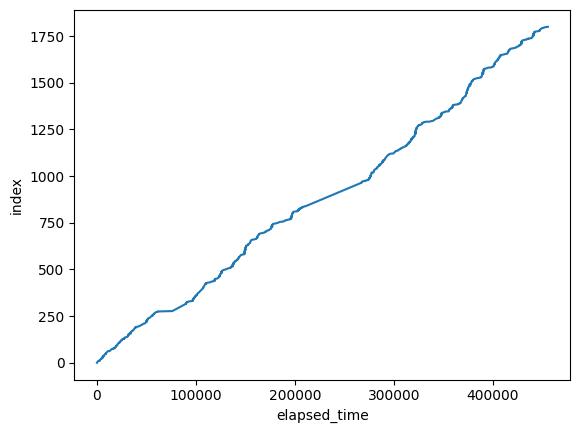

In [86]:
df_plot = (jogos.select("session_id", "index", "elapsed_time")
           .filter(F.col("session_id") == 22040212485055840)
           .toPandas())
df_plot
plot(df_plot, "elapsed_time", "index")

Observando a sessão que teve o **"menor"** tempo, é possivel visualizar que existe uma linha quase linear entre o **elapsed_time** e o **index**.

##### Extra

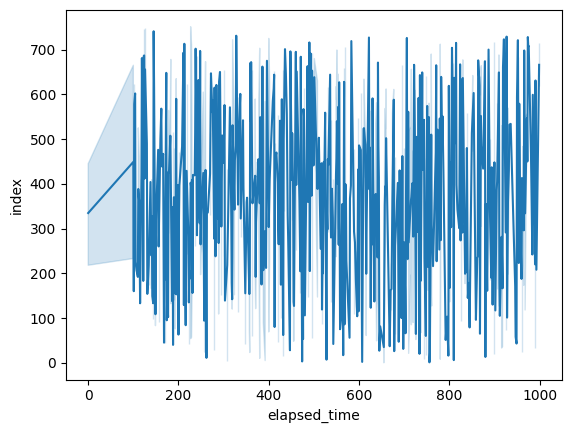

In [87]:
df_plot = (jogos.select("session_id", "index", "elapsed_time")
           .filter(F.col("session_id") == 21020618143279870)
           .toPandas())
df_plot
plot(df_plot, "elapsed_time", "index")

No gráfico acima, podemos encontrar a sessão que realmente possui o menor tempo e, se a visualizar-mos de forma crítica, é possivel verificar que esta possui dados que não fazem sentido. De forma a combater estes problema, o grupo utilizou na base de dados aplicável ao modelo, apenas o máxima de cada uma destas **features**, pois não existe a certeza, pela parte do grupo, de que esta sessão seja a única que possui este problema.

##### Mais Longo

In [88]:
jogos.select("*").groupBy("session_id").agg(F.max(F.col("elapsed_time"))).sort(F.col("max(elapsed_time)").desc()).show(1)

+-----------------+-----------------+
|       session_id|max(elapsed_time)|
+-----------------+-----------------+
|21040114240062616|       1988606704|
+-----------------+-----------------+
only showing top 1 row



(array([-2.50e+08,  0.00e+00,  2.50e+08,  5.00e+08,  7.50e+08,  1.00e+09,
         1.25e+09,  1.50e+09,  1.75e+09,  2.00e+09,  2.25e+09]),
 [Text(-250000000.0, 0, '−0.25'),
  Text(0.0, 0, '0.00'),
  Text(250000000.0, 0, '0.25'),
  Text(500000000.0, 0, '0.50'),
  Text(750000000.0, 0, '0.75'),
  Text(1000000000.0, 0, '1.00'),
  Text(1250000000.0, 0, '1.25'),
  Text(1500000000.0, 0, '1.50'),
  Text(1750000000.0, 0, '1.75'),
  Text(2000000000.0, 0, '2.00'),
  Text(2250000000.0, 0, '2.25')])

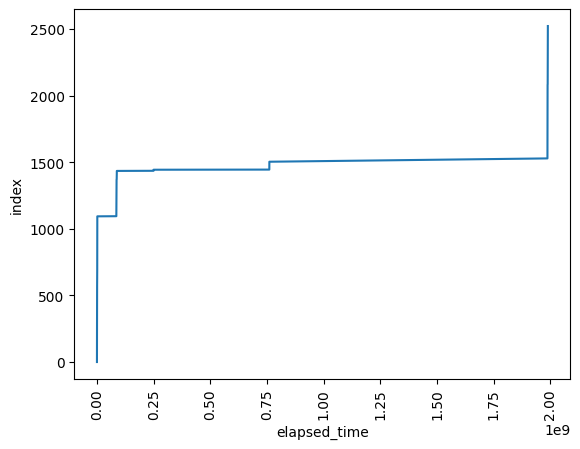

In [89]:
df_plot = (jogos.select("session_id", "index", "elapsed_time")
           .filter(F.col("session_id") == 21040114240062616)
           .toPandas())
plot(df_plot, "elapsed_time", "index")
plt.xticks(rotation=90)

Analisando de forma crítica a relação entre o **elapsed_time** e o **index**, é possivel verificar que, de forma oposta á sessão mais curta, não existe nenhuma curva linear na relação entre estas variáveis. Aparentemente, parece que esta relação é formada apenas por retas horizontais e verticais. 

### Salas do Jogo (room_fqid)

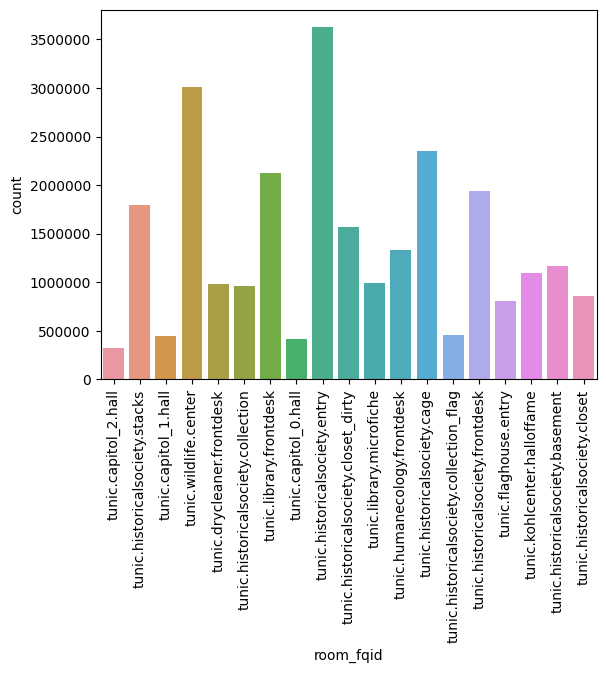

In [90]:
df_plot = (jogos.select("*")
           .groupBy("room_fqid")
           .count()
           .toPandas())
plotBar(df_plot, "room_fqid", "count", huecol=None)

O BarPlot acima mostra o numero de cliques em cada sala e, visualizando com alguma atenção, é possivel verificar que existe salas onde são feitos muitos mais cliques do que outros (possivelmente porque é onde existem mais personagens para interagir, ou porque é necessário lá voltar em níveis diferentes).

## Correlation plot sobre a nova base de dados

Iremos agora prosseguir para o correlation plot da base de dados criada após o feature engineering.

In [91]:
Games = spark.read.parquet('Games')
Games.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- level_group: string (nullable = true)
 |-- question: integer (nullable = true)
 |-- correct: integer (nullable = true)
 |-- ProbCorrect: double (nullable = true)
 |-- mean_screen_coor_x: double (nullable = true)
 |-- mean_screen_coor_y: double (nullable = true)
 |-- mean_room_coor_x: double (nullable = true)
 |-- mean_room_coor_y: double (nullable = true)
 |-- fullscreen: double (nullable = true)
 |-- hq: double (nullable = true)
 |-- music: double (nullable = true)
 |-- elapsed_time/sec: double (nullable = true)
 |-- TextCountDistinct: long (nullable = true)
 |-- navigate_click: long (nullable = true)
 |-- object_click: long (nullable = true)
 |-- notebook_click: long (nullable = true)
 |-- observation_click: long (nullable = true)
 |-- cutscene_click: long (nullable = true)
 |-- notification_click: long (nullable = true)
 |-- person_click: long (nullable = true)
 |-- map_hover: long (nullable = true)
 |-- map_click: long (nullable = t

In [92]:
# reduzir o tamanho da base de dados para a visualização dos dados que temos após o feature engineering
seed = 5
with_replacement = False
fraction = 0.05          # reduce to 5%
small_jogos = Games.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)
small_jogos.count()

21164

In [96]:
numeric_cols = ['session_id',
 # 'level_group',
 'question',
 'correct',
 'ProbCorrect',
 'mean_screen_coor_x',
 'mean_screen_coor_y',
 'mean_room_coor_x',
 'mean_room_coor_y',
 'fullscreen',
 'hq',
 'music',
 'elapsed_time/sec',
 'TextCountDistinct',
 'navigate_click',
 'object_click',
 'notebook_click',
 'observation_click',
 'cutscene_click',
 'notification_click',
 'person_click',
 'map_hover',
 'map_click',
 'object_hover',
 'hover_duration',
 'ComprimentoTexto',
 'NumeroEventos']

### Correlation Matrix

In [97]:
# The columns to compute correlations
cols_corr = numeric_cols

# DataSet sem nulos (Aqui preferimos usar o DataSet completo para obter uma maior veracidade das correlações)
jogosNoNull = Games.na.drop()

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col)
df_vector = assembler.transform(jogosNoNull).select(vector_col)

# get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

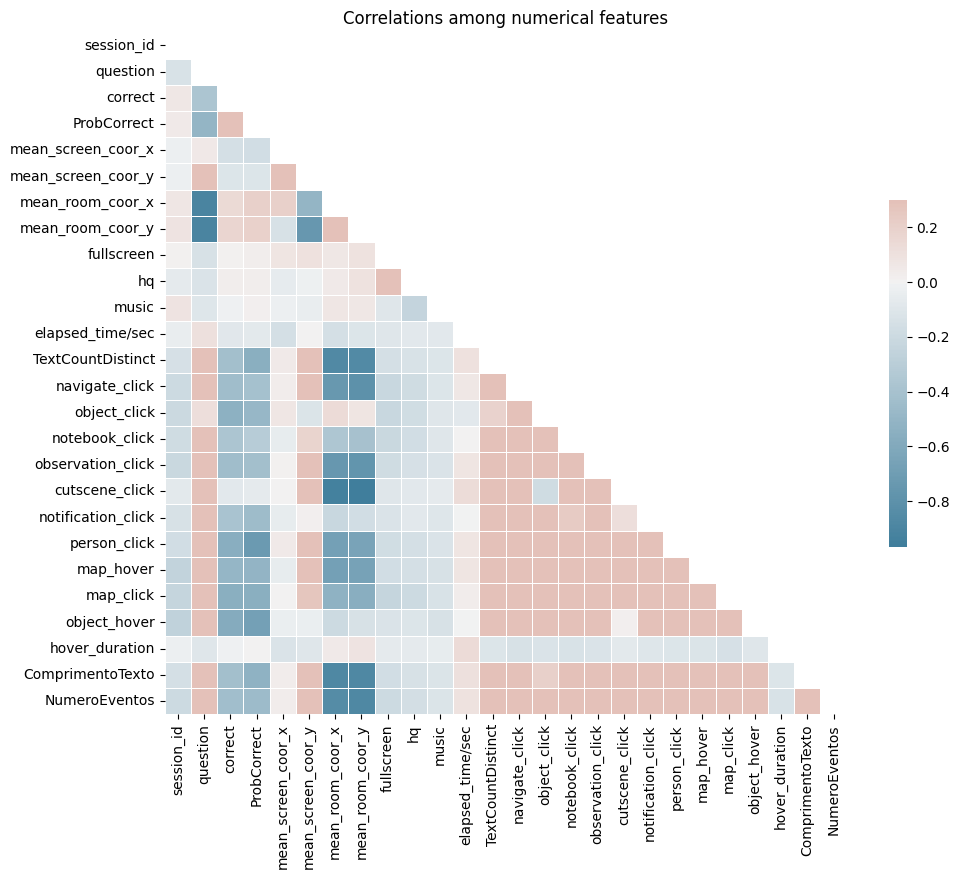

In [98]:
df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix_1(df_plot, annot=False)
plt.title('Correlations among numerical features')
plt.show()

Vemos que nada está muito correlacionado entre si, existindo correlações muito negativas.

## Labels

Seguiremos o mesmo processo para os labels.

### Questões respondidas corretamente

In [99]:
labels = spark.read.parquet('labels')
labels.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- level_group: string (nullable = true)
 |-- question: integer (nullable = true)
 |-- correct: integer (nullable = true)
 |-- ProbCorrect: double (nullable = true)



Pretende-se visualizar quais foram as perguntas mais acertadas, através de um gráfico de barras. Como os valores são 1 ou 0(certo ou errado), podemos utilizar a soma para descobrir. 

In [100]:
pivoted_df = labels.groupBy("question").pivot("correct").agg({"correct":"count"}).orderBy("question")
pdf = pivoted_df.toPandas()
pdf

question      0      1
0          1   6421  17141
1          2    499  23063
2          3   1555  22007
3          4   4754  18808
4          5  10644  12918
5          6   5279  18283
6          7   6219  17343
7          8   9019  14543
8          9   6214  17348
9         10  11653  11909
10        11   8397  15165
11        12   3229  20333
12        13  17080   6482
13        14   6888  16674
14        15  12228  11334
15        16   6247  17315
16        17   7356  16206
17        18   1163  22399

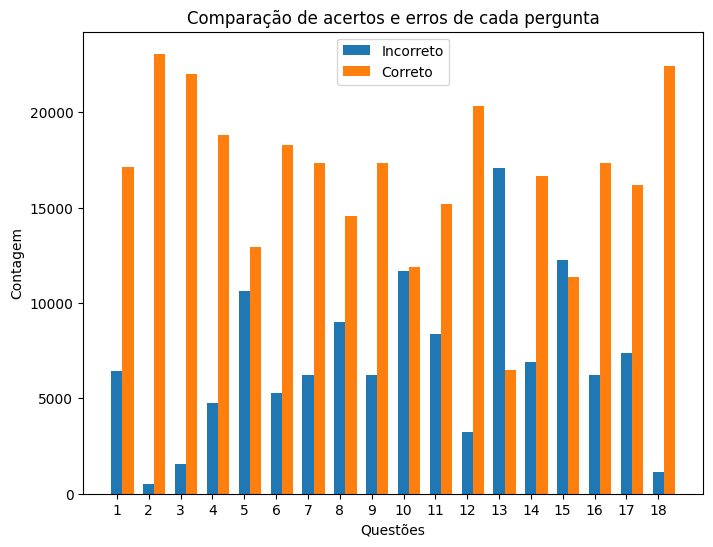

In [101]:
# Define o tamanho do gráfico
plt.figure(figsize=(8, 6))

# Define as variáveis para os eixos x e y
x = pdf["question"]
y1 = pdf["0"]
y2 = pdf["1"]

# Define a largura das barras
bar_width = 0.35

# Plota as barras para cada variável
plt.bar(x, y1, width=bar_width, align="center", label="Incorreto")
plt.bar(x + bar_width, y2, width=bar_width, align="center", label="Correto")
plt.xticks(x, [int(i) for i in x])
# Define os rótulos dos eixos x e y e o título do gráfico
plt.xlabel("Questões")
plt.ylabel("Contagem")
plt.title("Comparação de acertos e erros de cada pergunta")

# Adiciona a legenda ao gráfico
plt.legend()

# Exibe o gráfico
plt.show()

As perguntas mais acertadas foram as perguntas 2, 3 e 18.
\
As perguntas mais erradas foram as perguntas 13, 15 e 10.